In [6]:
import os
from glob import glob
import pandas as pd
from functools import reduce
import json
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Conv2D, AveragePooling2D, Dropout, Flatten, Dense

In [7]:
replace_text = lambda x: x.replace('\\','/')

image_list = glob('D:\Dataset\obj\*.jpg')
image_list = list(map(replace_text,image_list))

text_list = glob('D:\Dataset\obj\*.txt')
text_list = list(map(replace_text,text_list))

In [8]:
name = []

bbox_data = []

for i in range(len(text_list)):
    filename = text_list[i][text_list[i].rindex('/')+1:text_list[i].rindex('.')]
    with open(text_list[i],'r') as f:
        lines = f.readlines()
        if len(lines)>1:
            continue
    name.append(filename)
    bbox_data.append(lines[0].split())

df = pd.DataFrame(bbox_data,columns = ['class','x','y','w','h'])
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['w'] = df['w'].astype('float')
df['h'] = df['h'].astype('float')
df['class'] = df['class'].astype('int')
df['filename'] = name
df.head()

,class,x,y,w,h,filename
0,0,0.575238,0.414286,0.217143,0.348571,0-with-mask
1,1,0.458333,0.227778,0.383333,0.366667,0
2,0,0.538095,0.464286,0.363810,0.585714,1-with-mask
3,0,0.497854,0.390000,0.420601,0.277143,10-with-mask
4,0,0.500000,0.559579,0.618750,0.544393,100-with-mask


In [9]:
input_size = 244

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

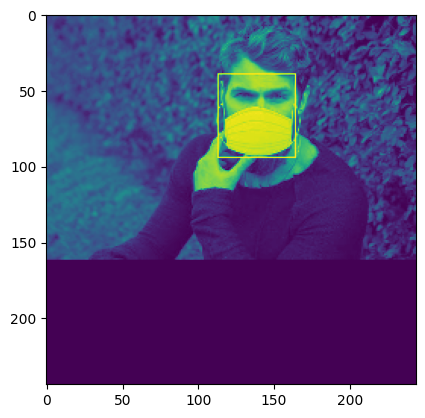

In [10]:
path = 'D:/Dataset/obj/'+df.iloc[0]['filename']+'.jpg'
img = cv2.imread(path,0)
box = [df.iloc[0]['x'],df.iloc[0]['y'],df.iloc[0]['w'],df.iloc[0]['h']]

new_image, new_box = format_image(img,box)

cv2.rectangle(new_image, new_box, color = (255,0,0))
plt.imshow(new_image)

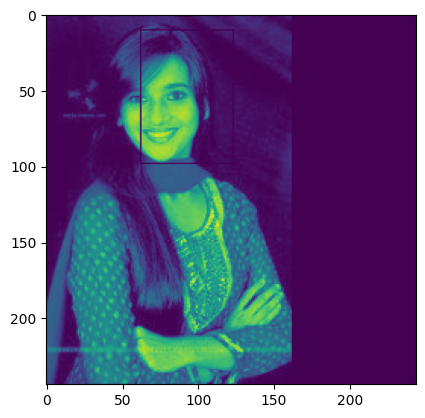

In [11]:
path = 'D:/Dataset/obj/'+df.iloc[1]['filename']+'.jpg'
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
box = [df.iloc[0]['x'],df.iloc[1]['y'],df.iloc[1]['w'],df.iloc[1]['h']]

new_image, new_box = format_image(img,box)

cv2.rectangle(new_image, new_box, color = (0,0,255))
plt.imshow(new_image)

In [12]:
def plot_with_bbox(path,ax):
    img = cv2.imread(path)

    image_name = path[path.rindex('/')+1:path.rindex('.')]+'.jpg'

    for idx,annotations in df[df['filename'] == image_name].iterrows():
        x_min, y_min = int(annotations['xmin']), int(annotations['ymin'])
        x_max, y_max = int(annotations['xmax']), int(annotations['ymax'])

        cv2.rectangle(img,(x_min,y_min),(x_max,y_max),color = (255,0,0), thickness=1)

    ax.imshow(img)
    ax.set_title(image_name)

In [13]:
X_train, X_test,y_train,y_test = train_test_split(df.drop('class',axis = 1),
                                                  df['class'],
                                                  stratify=df['class'],
                                                  test_size=0.2,
                                                  random_state = 42)

X_train, X_val,y_train,y_val = train_test_split(X_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  test_size=0.25,
                                                  random_state = 42)

In [14]:
def data_load(x,y, full_data_path = 'D:/Dataset/obj/',image_ext = '.jpg'):
    X = []
    Y = []

    for idx,file in x.iterrows():
        img = cv2.imread(full_data_path+file['filename']+image_ext,cv2.IMREAD_GRAYSCALE)

        box = np.asarray(file[:-1].values, dtype=float)

        if y.loc[idx] == 0:
            k = 0
        else:
            k = 1

        new_img,new_box = format_image(img,box)
        new_img = new_img.astype(float)/255.0
        new_box = np.asarray(new_box,dtype = float)/input_size
        label = np.append(new_box,k)

        X.append(new_img)
        Y.append(label)
    
    X = np.array(X)
    X = np.expand_dims(X, axis = 3)
    X = tf.convert_to_tensor(X , dtype= tf.float32)
    Y = tf.convert_to_tensor(Y, dtype= tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X,Y))

    return result


In [15]:
raw_train_ds = data_load(X_train,y_train)
raw_val_ds = data_load(X_val,y_val)
raw_test_ds = data_load(X_test,y_test)

In [16]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]),CLASSES), [label[0], label[1], label[2], label[3]])

In [17]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = tune_training_ds(raw_train_ds)

In [18]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(y_val.shape[0] // 4)
    dataset = dataset.repeat()
    return dataset

validation_ds = tune_validation_ds(raw_val_ds)

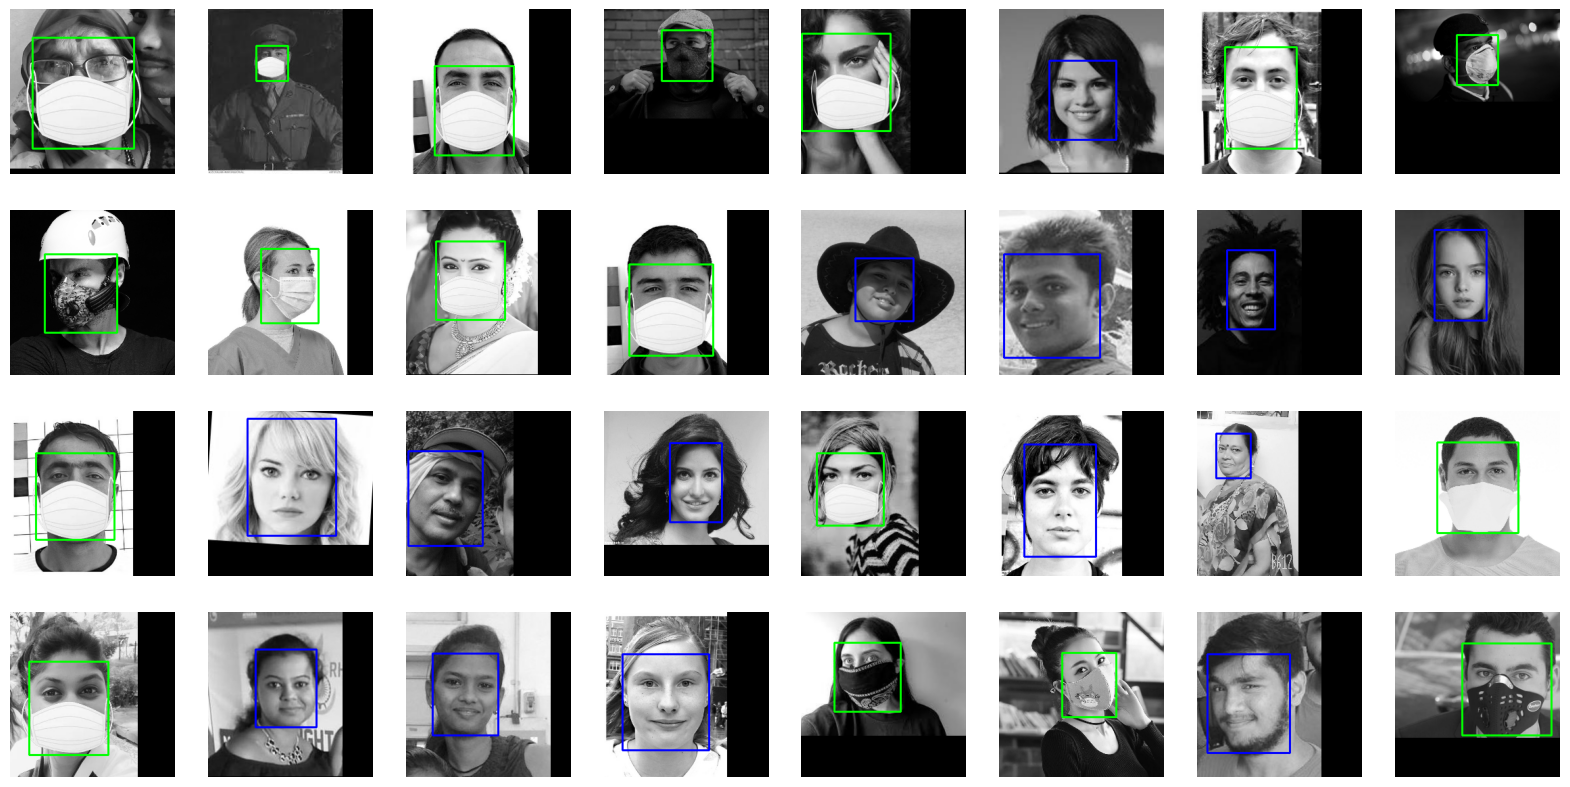

In [19]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv2.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

In [15]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = Conv2D(16, kernel_size=3, activation= 'relu', input_shape = (input_size, input_size,1))(inputs)
    x = AveragePooling2D(2,2)(x)
    
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):

    x = Flatten()(inputs)
    x = Dense(64,activation = 'relu')(x)

    return x

def build_classifier_head(inputs):
    return Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return Dense(4, name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer= keras.optimizers.Adam(), 
            loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
            metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model


In [16]:
model = build_model(keras.layers.Input(shape = (input_size, input_size,1)))

model.summary()

c:\Users\akhil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 242, 242,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 121, 121,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 119, 119,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 59, 59,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 57, 57,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 57, 57,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 28, 28,    │          0 │ dropout[0][0]     │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │  3,211,328 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_head     │ (None, 2)         │        130 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_head      │ (None, 4)         │        260 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
EPOCHS = 100

history = model.fit(train_ds,
                    steps_per_epoch=y_train.shape[0]//BATCH_SIZE,
                    validation_data=validation_ds,
                    validation_steps=1,
                    epochs = EPOCHS)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - classifier_head_accuracy: 0.6402 - loss: 1.1029 - regressor_head_mse: 0.4592 - val_classifier_head_accuracy: 0.6094 - val_loss: 0.6469 - val_regressor_head_mse: 0.0350
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - classifier_head_accuracy: 0.6468 - loss: 0.6250 - regressor_head_mse: 0.0260 - val_classifier_head_accuracy: 0.6406 - val_loss: 0.6251 - val_regressor_head_mse: 0.0256
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - classifier_head_accuracy: 0.7153 - loss: 0.5903 - regressor_head_mse: 0.0213 - val_classifier_head_accuracy: 0.5625 - val_loss: 0.6486 - val_regressor_head_mse: 0.0173
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - classifier_head_accuracy: 0.7378 - loss: 0.5603 - regressor_head_mse: 0.0189 - val_classifier_head_accuracy: 0.8750 - val_loss: 0.4805 - val_regressor_head_mse: 0.0279
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - classifier_head_accuracy: 0.8235 - loss: 0.4850 - reg

In [18]:
def i_o_u(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB-xA+1)*max(0, yB-yA+1)
    boxAArea = (boxA[2] + 1)*(boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    iou = interArea/float(boxAArea + boxBArea - interArea)
    return iou


In [24]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

20


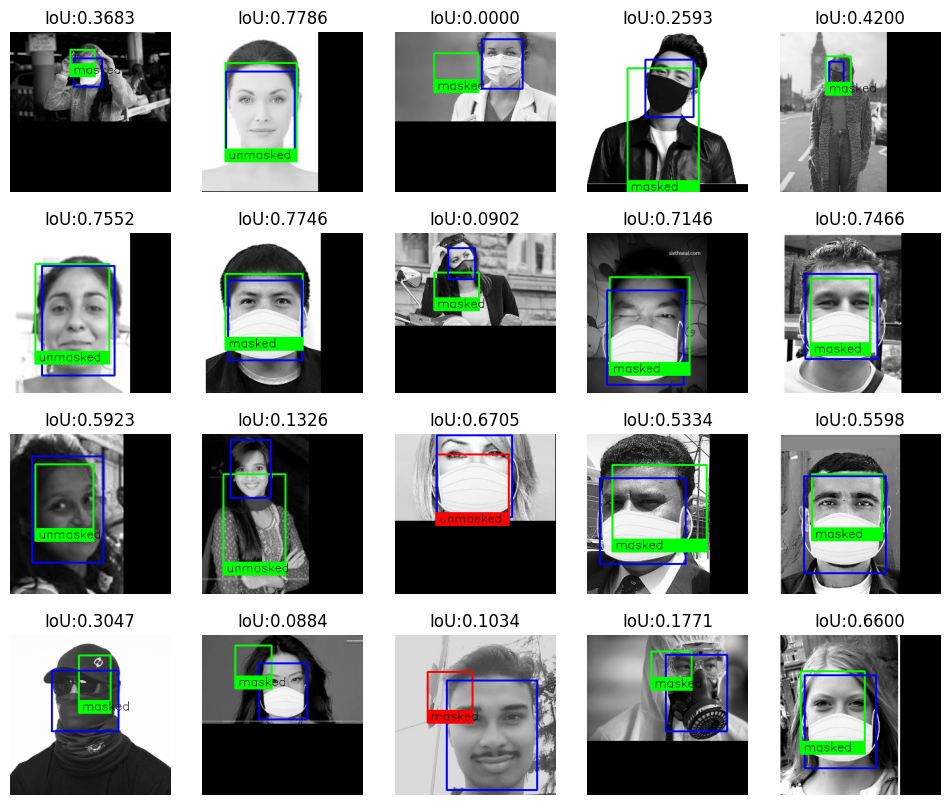

In [20]:
plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 5, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv2.rectangle(image_color, predicted_box_n, color, 2)
    cv2.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv2.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv2.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = i_o_u(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")